<a href="https://colab.research.google.com/github/inc0gnizant/CosmicFlaw/blob/main/FINAL_CataractCV-Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q efficientnet >> /dev/null

import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive

img_dir = "data.zip"


Mounted at /content/drive
/content/drive/MyDrive


In [5]:
img_size = 224

In [8]:


df_data = pd.read_csv('full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [9]:
df_data[df_data.C==1].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
65,81,66,Male,81_left.jpg,81_right.jpg,moderate non proliferative retinopathy，cataract,moderate non proliferative retinopathy，cataract,0,1,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",81_right.jpg
86,103,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",103_right.jpg
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg


In [10]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [11]:
df_data[df_data == 1].sum(axis=0)

,0
ID,2.0
Patient Age,28.0
Patient Sex,0
Left-Fundus,0
Right-Fundus,0
Left-Diagnostic Keywords,0
Right-Diagnostic Keywords,0
N,2101.0
D,2123.0
G,397.0


In [12]:
df_data2 = df_data.iloc[:, 1:7]
#df_data2['filepath'] = pd.Series(df_data['filepath'])
df_data2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [46]:
img_dir = "/content/drive/MyDrive/preprocessed_images"

In [14]:
# Left diagnosis with 'cataract' keyword

df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')].head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
86,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus
100,59,Male,119_left.jpg,119_right.jpg,cataract,drusen
218,60,Female,254_left.jpg,254_right.jpg,cataract,macular epiretinal membrane
256,69,Female,294_left.jpg,294_right.jpg,cataract,normal fundus


In [15]:
## let's place the left cataract data into its own dataframe and print the number of rows

df_left_cat = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')]
print(len(df_left_cat))

294


In [16]:
# Right diagnosis with 'cataract' keyword

df_data[df_data['Right-Diagnostic Keywords'].str.match('cataract')].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg
160,188,55,Female,188_left.jpg,188_right.jpg,laser spot，severe proliferative diabetic retin...,cataract,0,1,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",188_right.jpg
186,218,36,Female,218_left.jpg,218_right.jpg,refractive media opacity,cataract,0,0,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",218_right.jpg
309,354,65,Male,354_left.jpg,354_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",354_right.jpg


In [17]:
## let's place the right cataract data into its own dataframe and print the number of rows

df_rt_cat = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('cataract')]
print(len(df_rt_cat))

278


In [29]:
df_cat_filenames = pd.concat([df_left_cat['Left-Fundus'], df_rt_cat['Right-Fundus']], ignore_index=True)


df_cat_filenames.head()

,0
0,0_left.jpg
1,103_left.jpg
2,119_left.jpg
3,254_left.jpg
4,294_left.jpg


In [31]:
df_cat_filenames.tail()

,0
567,2243_right.jpg
568,2246_right.jpg
569,2247_right.jpg
570,2248_right.jpg
571,2282_right.jpg


In [32]:
len(df_cat_filenames)

572

(512, 512, 3)
2120_right.jpg


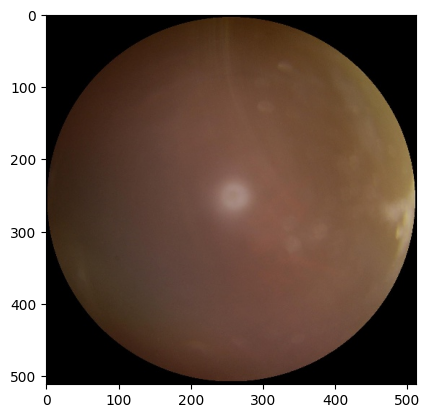

In [48]:

import os
if not os.path.exists(img_dir):
    print(f"File does not exist: {img_dir}")





img = df_cat_filenames[342]
image = cv2.imread(os.path.join(img_dir, img))
# Convert image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert image data to float32 and normalize to the range [0, 1]
image = image_rgb.astype(np.float32) / 255.0

plt.imshow(image)
print(image.shape)
print(img)

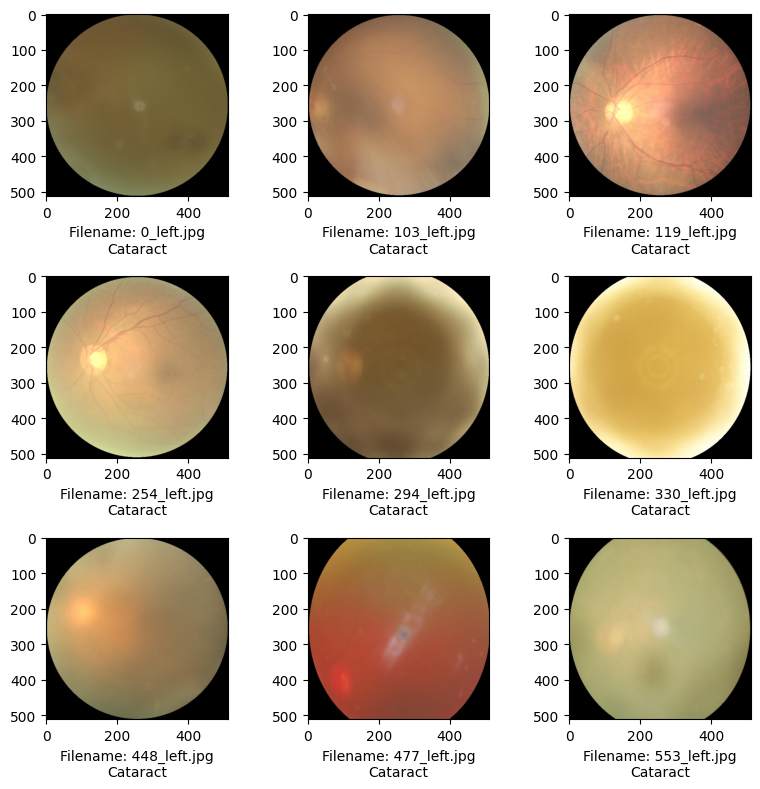

In [49]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_cat_filenames[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)

    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Cataract'.format(df_cat_filenames[i]))

plt.tight_layout()

In [50]:
df_data[df_data == 1].sum(axis=0)

,0
ID,2.0
Patient Age,28.0
Patient Sex,0
Left-Fundus,0
Right-Fundus,0
Left-Diagnostic Keywords,0
Right-Diagnostic Keywords,0
N,2101.0
D,2123.0
G,397.0


In [51]:
df_data2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [57]:
## let's place the Normal data into its own dataframe and print the number of rows

df_left_norm = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('normal')]
df_rt_norm = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('normal')]

print(len(df_left_norm))

2855


In [58]:
df_norm_filenames = pd.concat([df_left_norm['Left-Fundus'], df_rt_norm['Right-Fundus']], ignore_index=True)
df_norm_filenames

,0
0,1_left.jpg
1,8_left.jpg
2,9_left.jpg
3,14_left.jpg
4,15_left.jpg
...,...
5585,4642_right.jpg
5586,4644_right.jpg
5587,4660_right.jpg
5588,4671_right.jpg


In [59]:
## remember we're choosing 572 to equal the number of cataract images we pulled

df_norm_filenames_random = df_norm_filenames.sample(n = 572)
df_norm_filenames_random.head()

## looks like the index is out of order now that we got all the randos

,0
4445,1171_right.jpg
4786,2645_right.jpg
823,2957_left.jpg
2932,394_right.jpg
135,732_left.jpg


In [60]:
## we will reset the index as well
df_norm_filenames_random = df_norm_filenames_random.reset_index(drop=True)
df_norm_filenames_random

,0
0,1171_right.jpg
1,2645_right.jpg
2,2957_left.jpg
3,394_right.jpg
4,732_left.jpg
...,...
567,2861_left.jpg
568,2502_right.jpg
569,302_left.jpg
570,2595_left.jpg


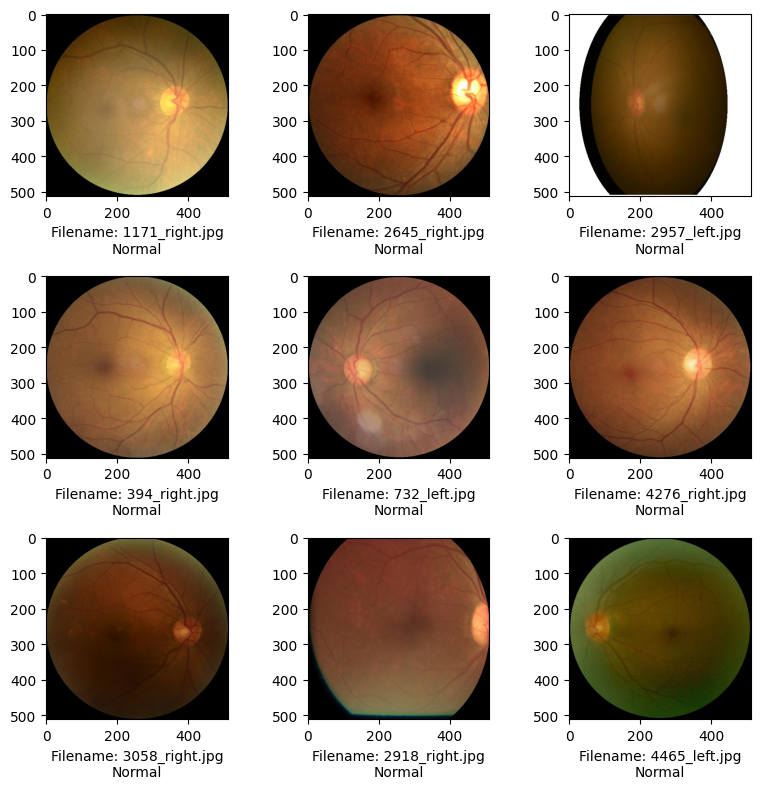

In [61]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_norm_filenames_random[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)

    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Normal'.format(df_norm_filenames_random[i]))

plt.tight_layout()

In [62]:
df_cat_filenames = pd.DataFrame(df_cat_filenames, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_cat_filenames["label"] = "cataract"

df_cat_filenames.head()

,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract


In [63]:
df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_norm_filenames_random["label"] = "normal"

df_norm_filenames_random.head()

,filename,label
0,1171_right.jpg,normal
1,2645_right.jpg,normal
2,2957_left.jpg,normal
3,394_right.jpg,normal
4,732_left.jpg,normal


In [65]:
df_combined = pd.concat([df_cat_filenames, df_norm_filenames_random], ignore_index=True)
df_combined

,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract
...,...,...
1139,2861_left.jpg,normal
1140,2502_right.jpg,normal
1141,302_left.jpg,normal
1142,2595_left.jpg,normal


In [66]:
df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

,filename,label
0,2951_left.jpg,normal
1,354_right.jpg,cataract
2,188_right.jpg,cataract
3,2120_right.jpg,cataract
4,2226_right.jpg,cataract
...,...,...
1139,1987_left.jpg,cataract
1140,3105_left.jpg,normal
1141,2742_left.jpg,normal
1142,2833_right.jpg,normal


In [67]:
# pull 80% of the combined dataset and reserve it for the training data
# the data generator will automatically create a validation set for us later

df_train = df_combined_random.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_random))
print(len(df_train))
print(len(df_test))

1144
915
229


In [68]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,
#            width_shift_range=0.2,
#            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]
#            zoom_range=0.2
            )

## for testing we don't want to do too much augmentation, we'll just scale it.

test_datagen=ImageDataGenerator(rescale=1./255.)

In [69]:
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

In [70]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

## validation set is created from the training set,
## we set it at 20% of the training data in the previous code

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))



test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 732 validated image filenames belonging to 2 classes.
Found 183 validated image filenames belonging to 2 classes.
Found 229 validated image filenames belonging to 2 classes.


In [72]:
train_image_data, train_labels = next(train_generator)
#train_image_data[0]
train_image_data.shape

(32, 224, 224, 3)

In [73]:
train_labels[0]

array([1., 0.], dtype=float32)

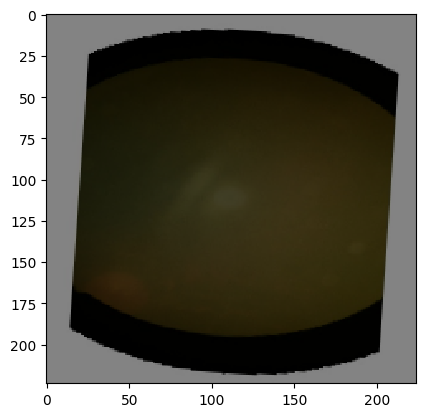

In [74]:
plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()
#images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

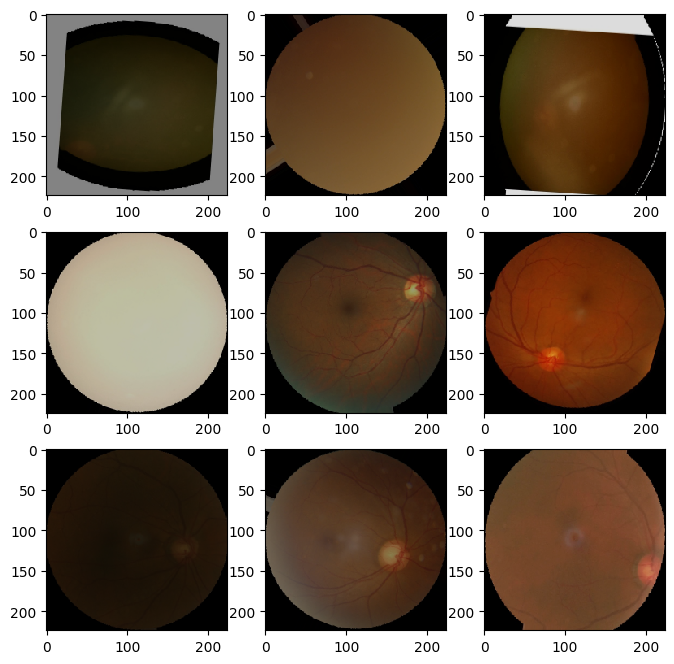

In [75]:
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_image_data[i], interpolation='nearest')

plt.show()

In [76]:
# get VGG16 base model
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# add new dense layers at the top
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

## remember we are using 2 outputs only
predictions = keras.layers.Dense(2, activation='softmax')(x)

# define and compile model
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [85]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_1.keras", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1, mode='auto')

In [94]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 4

print(n_spe,n_val_steps)

22 5


In [95]:
# get VGG16 base model
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# add new dense layers at the top
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

## remember we are using 2 outputs only
predictions = keras.layers.Dense(2, activation='softmax')(x)

# define model
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)

# Freeze VGG16 layers
for layer in vgg16.layers:
    layer.trainable = False

# Compile the model *after* adding new layers and freezing VGG16 layers
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



hist = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        callbacks=[checkpoint,early])

Epoch 1/4
22/22 ━━━━━━━━━━━━━━━━━━━━ 539s 24s/step - accuracy: 0.5430 - loss: 2.1762 - val_accuracy: 0.7500 - val_loss: 0.5780
Epoch 2/4
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 615ms/step - accuracy: 0.7143 - loss: 0.6055 - val_accuracy: 0.8696 - val_loss: 0.5194
Epoch 3/4
22/22 ━━━━━━━━━━━━━━━━━━━━ 516s 23s/step - accuracy: 0.7168 - loss: 0.6334 - val_accuracy: 0.8125 - val_loss: 0.3982
Epoch 4/4
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 625ms/step - accuracy: 0.8125 - loss: 0.5969 - val_accuracy: 0.7391 - val_loss: 0.6099


In [96]:
from keras.models import load_model
model = load_model('./vgg16_1.h5')

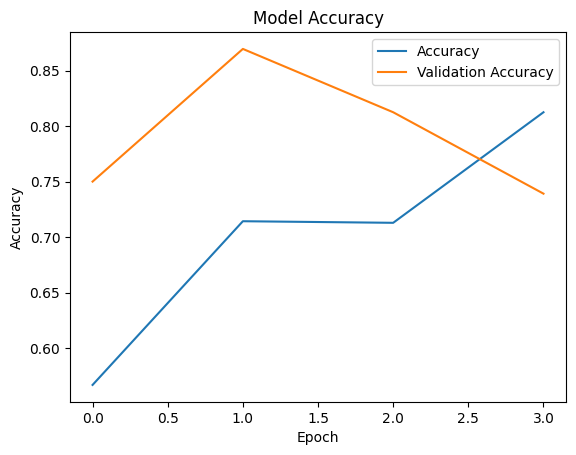

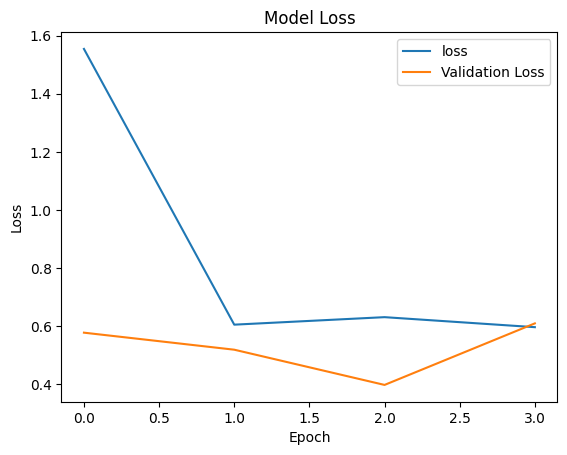

In [97]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

In [98]:
test_generator.reset()

In [101]:
pred = model.predict(test_generator, verbose=1, steps=int(test_generator.samples / batch_size))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 129s 18s/step


In [102]:
## let's get the first 10 rows
print(pred[0:10])

[[0.8293131  0.1706869 ]
 [0.23192674 0.7680734 ]
 [0.8007116  0.19928849]
 [0.46817204 0.5318279 ]
 [0.8326532  0.16734676]
 [0.685562   0.31443802]
 [0.88101065 0.11898936]
 [0.48631907 0.5136809 ]
 [0.8331826  0.16681728]
 [0.14314048 0.85685956]]


In [103]:
predicted_class_idx=np.argmax(pred,axis=1)

## print the same 10 rows

print(predicted_class_idx[0:10])

[0 1 0 1 0 0 0 1 0 1]


In [104]:
print(len(predicted_class_idx))

224


In [107]:
model.compile(loss=model.loss, optimizer=model.optimizer, metrics=['accuracy'])
results = model.evaluate(test_generator, verbose=1)
print(results)

8/8 ━━━━━━━━━━━━━━━━━━━━ 133s 16s/step - accuracy: 0.8613 - loss: 0.5448
[0.5487863421440125, 0.8602620363235474]


In [108]:
valid_generator.class_indices.items()

dict_items([('cataract', 0), ('normal', 1)])

In [109]:
valid_labels = dict((value,key) for key,value in valid_generator.class_indices.items())
pred_labels = [valid_labels[key] for key in predicted_class_idx]

In [110]:
pred_labels[1:10]

['normal',
 'cataract',
 'normal',
 'cataract',
 'cataract',
 'cataract',
 'normal',
 'cataract',
 'normal']

In [113]:
filenames = test_generator.filenames

# Ensure that the predicted labels have the same length as the filenames.
# This will select the first len(filenames) elements from pred_labels,
# which might result in loss of information if len(filenames) < len(pred_labels).
# Original: pred_labels = pred_labels[:len(filenames)]
# Modified to make sure pred_labels has the same length as filenames
pred_labels = pred_labels[:min(len(filenames), len(pred_labels))]
filenames = filenames[:min(len(filenames), len(pred_labels))]

# Create the DataFrame.
prediction_df = pd.DataFrame({'Filename': filenames, 'Prediction': pred_labels})

# Display the first few rows of the DataFrame.
prediction_df.head()

,Filename,Prediction
0,354_right.jpg,cataract
1,2436_left.jpg,normal
2,625_left.jpg,cataract
3,3009_left.jpg,normal
4,2120_left.jpg,cataract


In [114]:
prediction_df.iloc[35]

,35
Filename,1126_right.jpg
Prediction,cataract


In [115]:
print(test_generator.filenames[35])
print(test_generator.labels[35])

1126_right.jpg
0


In [116]:
test_file_names=test_generator.filenames  # sequential list of name of test files of each sample
test_labels=test_generator.labels # is a sequential list  of test labels for each image sample
class_dict= test_generator.class_indices # a dictionary where key is the class name and value is the label for the class

print (class_dict) # have a look at the dictionary

new_dict={}

for key in class_dict: # set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value = class_dict[key]
    new_dict[value] = key

print('  RESULT  PREDICT      TRUE CLASS       FILENAME ' ) # adjust spacing based on your class names
for i, p in enumerate(pred):
    pred_index=np.argmax(p) # get the index that has the highest probability
    pred_class=new_dict[pred_index]  # find the predicted class based on the index
    true_class=new_dict[test_labels[i]] # use the test label to get the true class of the test file
    file=test_file_names[i]

    if true_class == pred_class:
        result = "Correct"
    else:
        result = "Wrong  "


    print(f' {result}   {pred_class}    {true_class}      {file}')

{'cataract': 0, 'normal': 1}
  RESULT  PREDICT      TRUE CLASS       FILENAME 
 Correct   cataract    cataract      354_right.jpg
 Correct   normal    normal      2436_left.jpg
 Correct   cataract    cataract      625_left.jpg
 Correct   normal    normal      3009_left.jpg
 Correct   cataract    cataract      2120_left.jpg
 Correct   cataract    cataract      2243_left.jpg
 Correct   cataract    cataract      2115_right.jpg
 Correct   normal    normal      2818_right.jpg
 Correct   cataract    cataract      2241_left.jpg
 Correct   normal    normal      3015_right.jpg
 Correct   cataract    cataract      2128_right.jpg
 Wrong     cataract    normal      3170_left.jpg
 Correct   normal    normal      84_left.jpg
 Correct   cataract    cataract      2195_right.jpg
 Correct   cataract    cataract      1144_left.jpg
 Correct   cataract    cataract      560_right.jpg
 Correct   normal    normal      3417_right.jpg
 Wrong     cataract    normal      2969_left.jpg
 Correct   normal    normal 

In [119]:
test_image_data, test_labels = next(test_generator)

In [120]:
print(test_image_data.shape)
print(test_labels.shape)

(32, 224, 224, 3)
(32, 2)


In [121]:
z = 0
#test filename

test_file_names=test_generator.filenames[z]
print(test_file_names)

test_labels_example=test_generator.labels[z]
print(test_labels_example)

pred_labels[z]

354_right.jpg
0


'cataract'

In [122]:
test_labels[5]

array([1., 0.], dtype=float32)

In [123]:
test_class_idx=np.argmax(test_labels,axis=1)
#test_class_idx[4]
test_class_idx

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1])

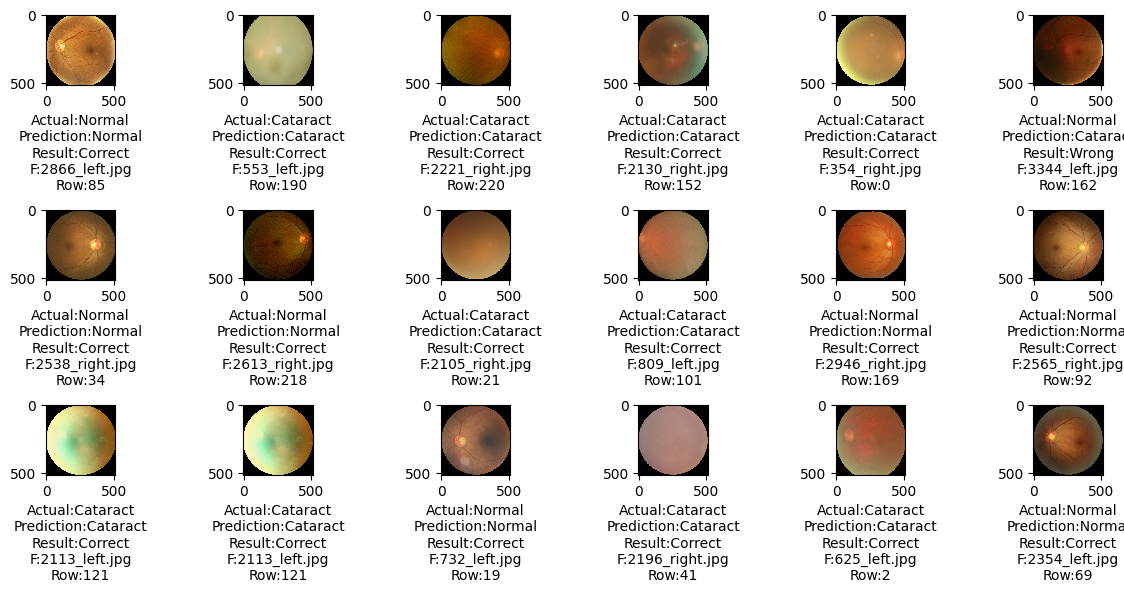

In [126]:
plt.figure(figsize=(12,6))
for i in range(18):
    sample = random.choice(range(test_generator.samples))
#    print(str(sample))
    img = test_generator.filenames[sample]
    image = cv2.imread(os.path.join(img_dir, img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    category = test_generator.labels[sample]
    pred_category = pred_labels[sample]

#    sample = random.choice(range(0,test_generator.samples))
#    image = test_image_data[sample]
#    category = test_class_idx[sample]
#    pred_category = pred_labels[sample]


    if category== 1:
        label = "Normal"
    else:
        label = "Cataract"

    if pred_category== "normal":
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    if label == pred_label:
        result = "Correct"
    else:
        result = "Wrong"


    plt.subplot(3,6,i+1)
    plt.imshow(image_rgb, interpolation='nearest')
    plt.xlabel("Actual:{}\nPrediction:{}\nResult:{}\nF:{}\nRow:{}".format(label,
                                                                          pred_label,
                                                                          result,
                                                                          test_generator.filenames[sample],
                                                                          sample))
plt.tight_layout()

In [129]:

from sklearn.metrics import classification_report

# Calculate the total number of samples in the test set.
total_test_samples = test_generator.samples

# Calculate the number of steps needed to cover all samples.
steps = (total_test_samples + test_generator.batch_size - 1) // test_generator.batch_size

# Get predictions for all test samples.
pred = model.predict(test_generator, verbose=1, steps=steps)

# Get predicted class indices for all test samples.
predicted_class_idx = np.argmax(pred, axis=1)

# Now, predicted_class_idx and test_generator.classes should have the same length.
print('Classification REPORT:')
target_names = ['Cataract', 'Normal']
print(classification_report(test_generator.classes, predicted_class_idx, target_names=target_names))

8/8 ━━━━━━━━━━━━━━━━━━━━ 133s 16s/step
Classification REPORT:
              precision    recall  f1-score   support

    Cataract       0.79      0.98      0.87       113
      Normal       0.98      0.74      0.84       116

    accuracy                           0.86       229
   macro avg       0.88      0.86      0.86       229
weighted avg       0.88      0.86      0.86       229



In [135]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_generator.labels, predicted_class_idx)
print('Confusion Matrix')
cm

Confusion Matrix


array([[111,   2],
       [ 30,  86]])

In [131]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [136]:
cm_plot_labels = ['cataract','normal']

Confusion matrix, without normalization
[[111   2]
 [ 30  86]]


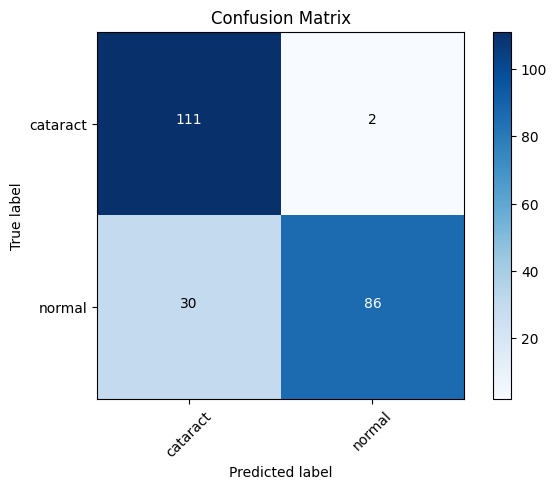

In [137]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')